In [405]:
import numpy as np
%matplotlib inline
from pylab import *
import matplotlib.pyplot as plt

#loading the data
classA_data = np.loadtxt('classA_train.dat', delimiter='\t')
classB_data = np.loadtxt('classB_train.dat', delimiter='\t')
test_A = np.loadtxt('classA_test.dat', delimiter='\t', dtype=np.float64)
test_B = np.loadtxt('classB_test.dat', delimiter='\t', dtype=np.float64)

np.set_printoptions(precision=17, suppress=False)


#pre-processing
angles_A=classA_data -0.5
angles_B=classB_data -0.5

test_A=test_A -0.5 
test_B=test_B -0.5
print('test A')
print(test_A)
print('test B')

print(test_B)

test A
[[ 0.487963798863549    0.5402435194046831  -0.4649422053691522 ]
 [-0.49177858366083926 -0.5137163891544169  -0.47245235927486817]
 [ 0.4929553795615269  -0.4814585984142239   0.48787918335594416]
 [ 0.5559733917095844   0.5324363992006131  -0.4965865413446003 ]
 [-0.5249546359001747  -0.488686714013272   -0.5154570858061859 ]
 [-0.45134427585548065 -0.5218766201460632  -0.5374442878413899 ]
 [-0.5111259139222607   0.5301348500729364   0.5165490362313656 ]
 [ 0.529169931745636   -0.49962332183926556  0.5142807910238907 ]
 [-0.48977080040792237  0.4922424008183224   0.5334222956591084 ]
 [-0.46431261591330575 -0.45484039322127906 -0.5003621171181556 ]]
test B
[[ 0.5148830076100039  -0.5316415813343313  -0.524519880520645  ]
 [-0.49771911926868717  0.5239895857612853  -0.4989108140856221 ]
 [-0.5099470287243149   0.4506498857032867  -0.48652750591780186]
 [ 0.41944513646780446 -0.5414304357369     -0.5445764127020688 ]
 [ 0.5229695508457846  -0.5000251826060452  -0.52334695688040

In [406]:

#Define the Ry gate
def apply_Ry(state, theta):
    cos=np.cos(theta/2)
    sin=np.sin(theta/2)
    Ry=np.array([[cos, -sin], [sin, cos]], dtype=complex)
    new_state = np.dot(Ry, state)
    return new_state # / np.linalg.norm(new_state)
    

#cnot
def apply_NOT(control, target):
    CNOT = np.array([
        [1, 0, 0, 0],
        [0, 1, 0, 0],
        [0, 0, 0, 1],
        [0, 0, 1, 0]
    ], dtype=complex)
    # Flatten and concatenate the control and target qubits
    combined_state = np.dot(CNOT, np.concatenate([control.flatten(), target.flatten()]))

    new_control = np.array([combined_state[0], combined_state[1]])  # Extract the updated state of the control qubit
    new_target = np.array([combined_state[2], combined_state[3]])  # Extract the updated state of the target qubit

    return new_control, new_target


#rx gate
def apply_Rx(state, theta):
    cos = np.cos(theta / 2)
    sin = np.sin(theta / 2)
    Rx = np.array([
        [cos, -1j * sin],
        [-1j * sin, cos]
    ], dtype=complex)
    new_state=np.dot(Rx, state)
    return new_state 




#ANGLE ENCODING 
def encode(angles):
    qubits=3
    final_states=[]
    
    #for each row of the data
    #The gate takes as theta the proproccessed classical data given 
    for angle in angles:
        #initialize qubits to |0>
        q_states=[np.array([1,0], dtype=complex) for _ in range(qubits)]
    
        #for each quantum state of the qbit apply the Ry gate
        for i in range(qubits):
            q_states[i]=apply_Ry(q_states[i], angle[i])
           
        final_states.append(q_states)
    return final_states


#VARIATIONAL MODEL
#Circuit
def circuit_(states, parameters):
    qubits=len(states[0])
    finals=[]
    for s in states:  
        new_state = [np.copy(q) for q in s]  # Copy the state to avoid in-place modifications
        for i in range(qubits): #for each qubit
            new_state[i] = apply_Rx(new_state[i], parameters[i])  #apply Rx
            new_state[i] = apply_Ry(new_state[i], parameters[i + qubits])  #apply Ry

        # Apply CNOT gate
        for i in range(qubits - 1):  # Loop over all qubits except the last one
            control = new_state[i]
            target = new_state[i + 1]
            newcontrol, newtarget = apply_NOT(control, target)
            new_state[i] = newcontrol  
            new_state[i + 1] = newtarget         
        finals.append(new_state)
    return finals



labels_A = np.ones(len(angles_A))   #1 if classA
labels_B = np.zeros(len(angles_B))   #0 if classB 

states_A=encode(angles_A)
states_B=encode(angles_B)
# Combine states and labels
combined_states = np.concatenate((states_A, states_B), axis=0)
combined_labels = np.concatenate((labels_A, labels_B), axis=0)












#def caclf(qstate):
   # ket=qstate
  #  bra = np.conj(ket).T
   # print(f'q state is {qstate}   *  {Z}')
   
   # m_res = np.dot(Z, ket)
    # Calculate f_theta(x) as bra * Z * ket
  #  f_theta = np.dot(bra, m_res)
 #   return np.real(f_theta)

#def measure(finals):
    #f_theta_product=1
      
    # print("state in final:", st)
    #for qstate in finals: #qbit
    #    f_theta=caclf(qstate)
   #     f_theta_product*=f_theta
 #   print(f_theta_product)
  #  f_thetas.append(1 if f_theta_product >0 else 0)

 #   return f_thetas
#


def calc_probs(state):
    probability_0=1   #classB
    probability_1=1   #classA 

    for qstate in state:
        total_prob_amplitude = np.sqrt(np.abs(qstate[0])**2 + np.abs(qstate[1])**2)

    # Normalize the state vector
        normalized_psi = qstate / total_prob_amplitude
                
    # calculate the probabilities after normalization
        prob_0 = np.abs(normalized_psi[0])**2
        prob_1 = np.abs(normalized_psi[1])**2
        probability_0*=prob_0
        probability_1*=prob_1

   # print(f'prob 0 for classB is: {prob_0} and prob 1 for classA is: {prob_1}')
    return prob_0, prob_1





#dμfμ = (f_μ+ς - f_μ-ς)/2sin(s)
def parametershift(circuit_, parameters, data, labels):
    #gia kathe parameter calculate gradient
    gradients=np.zeros_like(parameters)
    shift=np.pi/2
    for i in range(len(parameters)):

        # Shift parameter theta_i by +pi/2
        shifted_params_plus = parameters.copy()
        shifted_params_plus[i] += shift
        
        # Shift parameter theta_i by -pi/2
        shifted_params_minus = parameters.copy()
        shifted_params_minus[i] -= shift

        #Apply the circuit with the shifted thetas
        finals_plus=circuit_(data, shifted_params_plus)
        finals_minus=circuit_(data, shifted_params_minus)

        #Calculate the probabilities and the f_theta for each state
        pr_0_plus=[]
        pr_1_plus=[]
        f_theta_plus=[]
        for state in finals_plus:
            pr_0_p , pr_1_p=calc_probs(state)
            pr_0_plus.append(pr_0_p)
            pr_1_plus.append(pr_1_p)

            f_theta_p=(1 if pr_1_p>pr_0_p else 0)
            f_theta_plus.append(f_theta_p)
            
            
        #Calculate the loss
        loss_plus=cross_entropy_loss(pr_0_plus, pr_1_plus, labels)

        
        pr_0_minus=[]
        pr_1_minus=[]
        f_theta_minus=[]
        for state in finals_minus:
            pr_0_m , pr_1_m=calc_probs(state)
            pr_0_minus.append(pr_0_m)
            pr_1_minus.append(pr_1_m)

            f_theta_m=(1 if pr_1_m>pr_0_m else 0)
            f_theta_minus.append(f_theta_m)
            
            
        
        
        loss_minus=cross_entropy_loss(pr_0_minus, pr_1_minus, labels)
        #find the gradient: dμfμ = (f_μ+ς - f_μ-ς)/2sin(s)
        gradients[i] = (loss_plus - loss_minus) / (2 * np.sin(shift))

   # print(gradients)
        
    return gradients






Z= np.array([[1, 0], [0, -1]], dtype=complex)
basis_state0=np.array([1 , 0], dtype=complex)    #|0> state
basis_state1=np.array([0 , 1 ], dtype=complex)   #|1> state


# Cross-entropy loss function
def cross_entropy_loss(prob_0, prob_1, labels):

    epsilon = 1e-10  # Small epsilon value to avoid log(0)

    # Ensure predictions are clipped to avoid log(0)
    prob_1 = np.maximum(epsilon, np.minimum(1 - epsilon, prob_1))  #classA
    prob_0 = np.maximum(epsilon, np.minimum(1 - epsilon, prob_0))  #classB 
    
    # Calculate binary cross-entropy loss
    loss = -np.mean(labels * np.log(prob_1) + (1 - labels) * np.log(prob_0))
    return loss




#function to calculate the accuracy of the predictions 
def ac_calc(preds, labels):
    #print(f'preds are {preds} , labels are {labels}')
    corrects=np.sum(preds==labels)
    totals=len(preds)
    return corrects/totals



num_qubits = 3
num_params = 2 * num_qubits  # Each qubit has Rx and Ry

std_dev = 0.1
learning_rate = 0.3

# Initialize parameters from a normal distribution
parameters = np.random.randn(num_params) * std_dev #initial

losses=[]
accuracies=[]

num_epochs=35   #number of epochs 

incorrectly_predicted_states=[] #List of the incorrectly predicted states used for plotting
correctly_predicted_states=[] #List of the correctly predicted states used for plotting
for epoch in range(num_epochs):

    probabilities_0=[]
    probabilities_1=[]
    f_thetas=[]
    #print(parameters)

    finals=circuit_(combined_states, parameters)  #apply circuit 


    for i,state in enumerate(finals):
        
        prob_0 , prob_1 = calc_probs(state)
        #1 class A , 0 class B 
        probabilities_0.append(prob_0)
        probabilities_1.append(prob_1)
        f_theta=(1 if prob_1>prob_0 else 0)   #1 for class A - 0 for class B 
        f_thetas.append(f_theta)

     #   if epoch==num_epochs -1:
      #      print(f'Label: {combined_labels[i]}, Predicted: {f_theta}, prob 0 {prob_0} , prob 1 {prob_1}')

        # Extract incorrectly predicted states and labels
        if f_theta != combined_labels[i]:
            incorrectly_predicted_states.append(state)

        else:
            correctly_predicted_states.append(state)

    

 #   print(f_thetas)
    accuracy=ac_calc(np.array(f_thetas),combined_labels)
    accuracies.append(accuracy)
    loss=cross_entropy_loss(probabilities_0, probabilities_1, combined_labels)
    losses.append(loss)
    #print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss}')


#OPTIMIZATION
    gradients = parametershift(circuit_, parameters, combined_states, combined_labels)
    #print(f'Gradients: {gradients}')
    parameters -= learning_rate * gradients




#Mean accuracy
meanac=sum(accuracies)/len(accuracies)
#Mean loss
meanloss=sum(losses)/len(losses)



#TEST A 
#testing the circuit with the final parameters on the test data
probs_testA_0=[]
probs_testA_1=[]

fthetas_testA=[]

test_A_en=encode(test_A)  #encoding
testA_finals=circuit_(test_A_en, parameters) #apply circuit
for state in testA_finals:
    prob_testA_0 , prob_testA_1 = calc_probs(state)  #calculate probabilities
    #1 class A , 0 class B 
    probs_testA_0.append(prob_testA_0)
    probs_testA_1.append(prob_testA_1)

    f_testA=(1 if prob_testA_1>prob_testA_0 else 0)
    fthetas_testA.append(f_testA)

testA_loss=cross_entropy_loss(probs_testA_0, probs_testA_1, labels_A[:len(fthetas_testA)])  #loss of testA data
accuracyA=ac_calc(np.array(fthetas_testA), labels_A[:len(fthetas_testA)])  



#TEST B
probs_testB_0=[]
probs_testB_1=[]
fthetas_testB=[]

test_B_en=encode(test_B)
testB_finals=circuit_(test_B_en, parameters)
#print(test[0])
for state in testB_finals:
    prob_testB_0 , prob_testB_1 = calc_probs(state)
    #1 class A , 0 class B 
    probs_testB_0.append(prob_testB_0)
    probs_testB_1.append(prob_testB_1)

    f_testB=(1 if prob_testB_1>prob_testB_0 else 0)
    fthetas_testB.append(f_testB)

testB_loss=cross_entropy_loss(probs_testB_0, probs_testB_1, labels_B[:len(fthetas_testB)])
accuracyB=ac_calc(np.array(fthetas_testB), labels_B[:len(fthetas_testB)])




print(f' Mean Accuracy: {meanac}       Mean Loss {meanloss}')
print(f' Test A Accuracy: {accuracyA}       Test B Accuracy: {accuracyB}') 
print(f' Test A Loss: {testA_loss}     Test B loss: {testB_loss}')






import random

I = np.array([[1,0] , [0,1]], dtype=complex)  #identity
X= np.array([[0,1] , [1,0]], dtype=complex)  #pauli-x
Y= np.array([[0,-i], [i,0]], dtype=complex)  #pauli-y
Z = np.array([[1,0], [0,-1]], dtype=complex) #pauli-z

paulis_and_eye=[I,X,Y,Z]

            
#Depolarizing s channel randomly applies
#one of the Pauli operations or leaves the quantum state unchanged, each with certain
#probabilities. As a result, the quantum state becomes more mixed.
def depolarizing(state,prob):
    if np.random.rand() < prob:
        matrix=random.choice(paulis_and_eye)
        return np.dot(matrix, state)

    return state

def bit_flip(state, prob):

    if np.random.rand() < prob:
        return np.dot(X, state)
        

    return state


def apply_NOT(control, target):
    CNOT = np.array([
        [1, 0, 0, 0],
        [0, 1, 0, 0],
        [0, 0, 0, 1],
        [0, 0, 1, 0]
    ], dtype=complex)
    # Flatten and concatenate the control and target qubits
    combined_state = np.dot(CNOT, np.concatenate([control.flatten(), target.flatten()]))

    # Reshape the combined state back into qubit states
    new_control = np.array([combined_state[0], combined_state[1]])  # Extract the updated state of the control qubit
    new_target = np.array([combined_state[2], combined_state[3]])  # Extract the updated state of the target qubit

    return new_control, new_target

#Changed the encoding funtion so that it adds noise
def noisy_encoding(states):
    qubits=3
    encoded=[]
    for state in states:
        q_states = [np.array([1, 0], dtype=complex) for _ in range(qubits)]
        for i in range(qubits):
            q_states[i]=apply_Ry(q_states[i], state[i])
            #noise
            q_states[i]=depolarizing(q_states[i], 0.1)  #noise  with pr=10%

        encoded.append(q_states)

    return encoded


                                 
#changed the circuit function to add noise
def noisy_circuit(states, parameters):
    qbits=3
    final_n=[]
    for state in states:
        new_state = [np.copy(q) for q in state]
        for i in range(qbits):
            new_state[i] = apply_Rx(new_state[i], parameters[i])
            new_state[i] = depolarizing(new_state[i], 0.1)  # Apply noise
            new_state[i] = apply_Ry(new_state[i], parameters[i + qbits])
            new_state[i] = depolarizing(new_state[i], 0.1)  # Apply noise   

        for i in range(qbits - 1):  # Loop over all qubits except the last one
            control = new_state[i]
            target = new_state[i + 1]
            ncontrol, ntarget = apply_NOT(control, target)
            new_state[i] = ncontrol  # Extract the new state of control qubit
            new_state[i + 1] = ntarget 
            new_state[i]=depolarizing(new_state[i], 0.1)
            new_state[i+1]=depolarizing(new_state[i+1], 0.1)
            
        final_n.append(new_state)
    return final_n
    

num_qubits = 3
num_params = 2 * num_qubits  # Each qubit has Rx and Ry

std_dev = 0.1

# Initialize parameters from a normal distribution
n_parameters = np.random.randn(num_params) * std_dev

noises_A=noisy_encoding(angles_A)    #noisy encoding
noises_B=noisy_encoding(angles_B)
noisy_states = np.concatenate((noises_A, noises_B), axis=0)


n_losses=[]  #same as before, i store the loss and the accuracy value
n_accuracies=[]





n_incorrectly_predicted_states=[]  
n_correctly_predicted_states=[]
for epoch in range(num_epochs):  #same number of epochs

    probabilities_0=[]
    probabilities_1=[]
    f_thetas=[]
    #print(parameters)

    noisy_finals=noisy_circuit(noisy_states, n_parameters)  #using the updated circuit

#same as before
    for i,state in enumerate(noisy_finals):
        
        prob_0 , prob_1 = calc_probs(state)
        #1 class A , 0 class B 
        probabilities_0.append(prob_0)
        probabilities_1.append(prob_1)
        f_theta=(1 if prob_1>prob_0 else 0)
        f_thetas.append(f_theta)

        # Extract incorrectly predicted states and labels
        if f_theta != combined_labels[i]:
            n_incorrectly_predicted_states.append(state)

        else:
            n_correctly_predicted_states.append(state)

    

 #   print(f_thetas)
    n_ac=ac_calc(np.array(f_thetas),combined_labels)
    n_accuracies.append(n_ac)
    n_loss=cross_entropy_loss(probabilities_0, probabilities_1, combined_labels)
    n_losses.append(n_loss)
    #print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss}')


    
    gradients = parametershift(noisy_circuit, n_parameters, noisy_states, combined_labels)
    #print(f'Gradients: {gradients}')
    n_parameters -= learning_rate * gradients






meannac=sum(n_accuracies)/len(n_accuracies)
meannloss=sum(n_losses)/len(n_losses)


#Apply the model for the test data to see accuracy and loss with the optimized parameters

#TEST A 
#testing the circuit with the final parameters on the test data

n_probs_testA_0=[]
n_probs_testA_1=[]

n_fthetas_testA=[]

test_A_noises=noisy_encoding(test_A) #encoding 
n_testA_finals=noisy_circuit(test_A_noises, parameters) 

for state in n_testA_finals:
    prob_testA_0 , prob_testA_1 = calc_probs(state)
    #1 class A , 0 class B 
    n_probs_testA_0.append(prob_testA_0)
    n_probs_testA_1.append(prob_testA_1)

    f_testA=(1 if prob_testA_1>prob_testA_0 else 0)
    n_fthetas_testA.append(f_testA)

n_testA_loss=cross_entropy_loss(n_probs_testA_0, n_probs_testA_1, labels_A[:len(n_fthetas_testA)])
n_accuracyA=ac_calc(np.array(n_fthetas_testA), labels_A[:len(n_fthetas_testA)])



#TEST B 
n_probs_testB_0=[]
n_probs_testB_1=[]

n_fthetas_testB=[]

test_B_noises=noisy_encoding(test_B)
n_testB_finals=noisy_circuit(test_B_noises, parameters)

for state in n_testB_finals:
    prob_testB_0 , prob_testB_1 = calc_probs(state)
    #1 class A , 0 class B 
    n_probs_testB_0.append(prob_testB_0)
    n_probs_testB_1.append(prob_testB_1)

    f_testB=(1 if prob_testB_1>prob_testB_0 else 0)
    n_fthetas_testB.append(f_testB)

n_testB_loss=cross_entropy_loss(n_probs_testB_0, n_probs_testB_1, labels_B[:len(n_fthetas_testB)])
n_accuracyB=ac_calc(np.array(n_fthetas_testB), labels_B[:len(n_fthetas_testB)])

print('\n\n')
print(f' Mean Accuracy (noise): {meannac}     Mean Loss (noise): {meannloss}')
print(f' Test A (noise) Accuracy: {n_accuracyA}    Test B (noise) Accuracy: {n_accuracyB}')
print(f' Test A (noise) Loss: {n_testA_loss}    Test B (noise) Loss: {n_testB_loss}')




 Mean Accuracy: 0.5207142857142859       Mean Loss 1.390802618595084
 Test A Accuracy: 0.6       Test B Accuracy: 0.1
 Test A Loss: 0.6192137814757335     Test B loss: 1.4421535848989726



 Mean Accuracy (noise): 0.5614285714285715     Mean Loss (noise): 1.3322483358992112
 Test A (noise) Accuracy: 0.6    Test B (noise) Accuracy: 0.5
 Test A (noise) Loss: 0.6192137814757335    Test B (noise) Loss: 0.9301967773531832


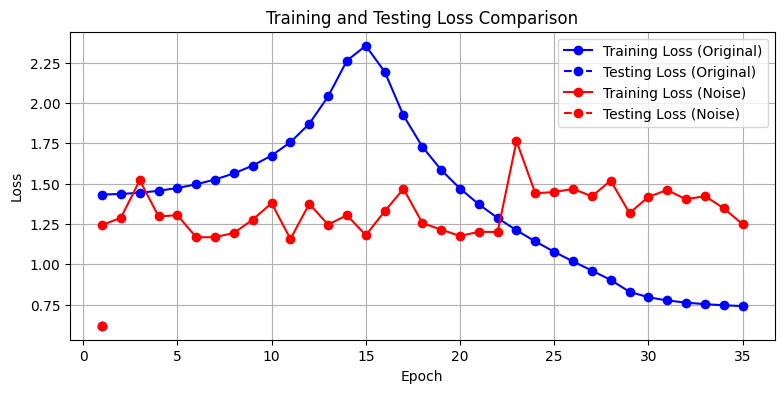

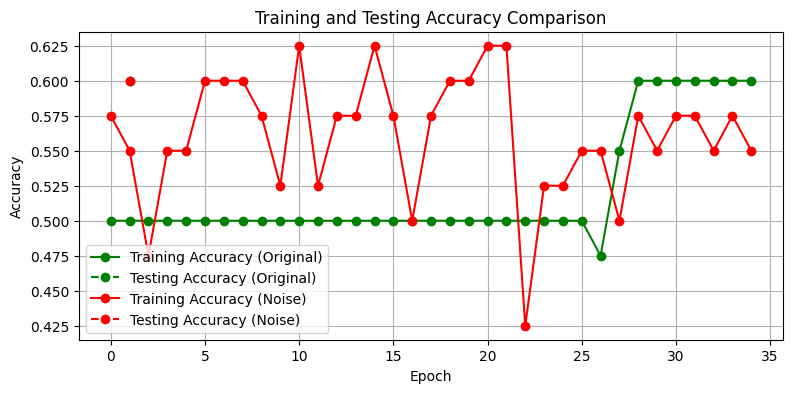

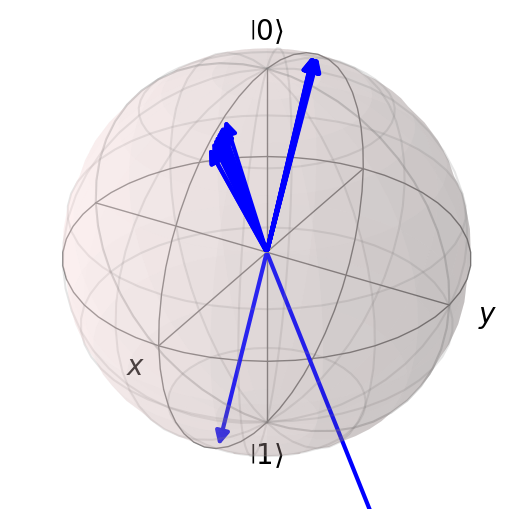

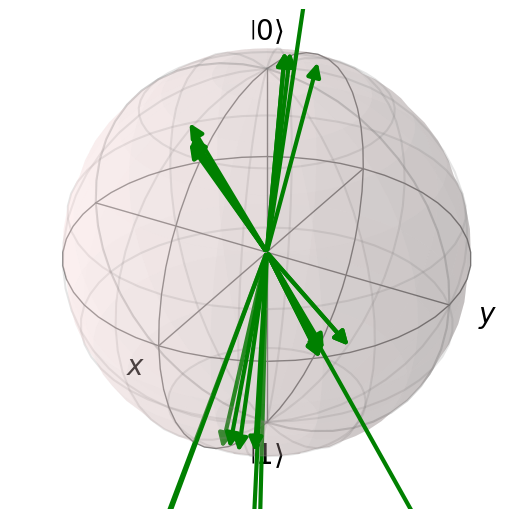

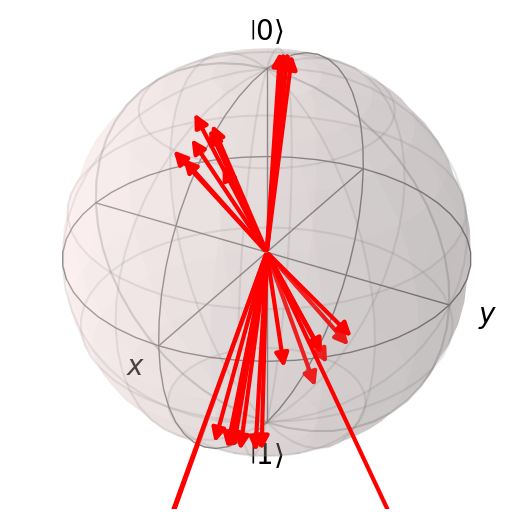

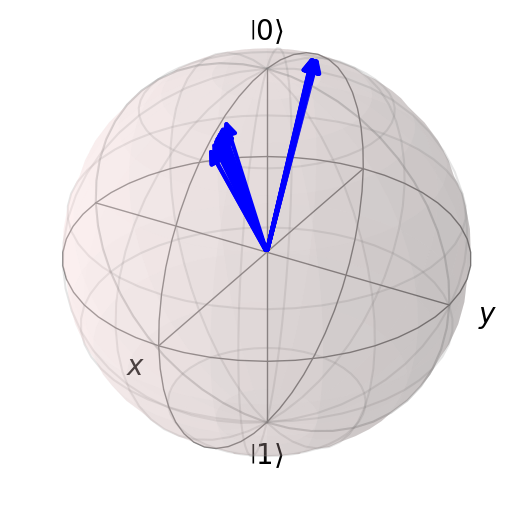

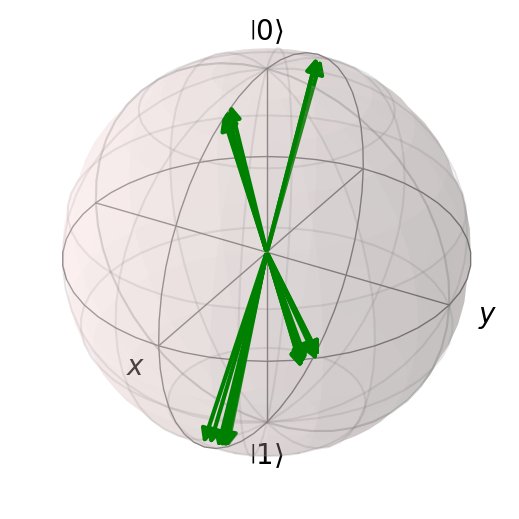

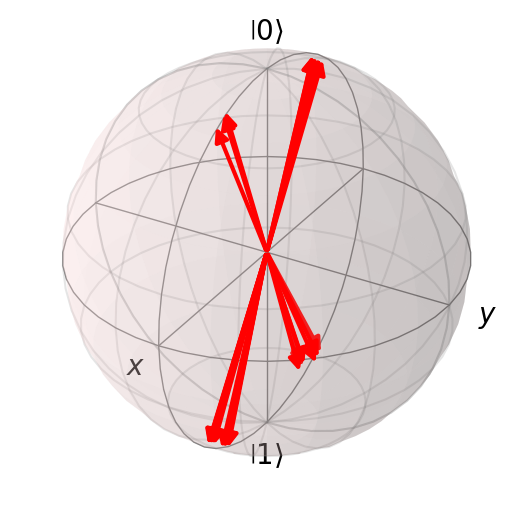

In [409]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import *




plt.figure(figsize=(20, 4))
plt.subplot(1, 2, 1)

plt.plot(range(1, num_epochs + 1), losses,marker='o', linestyle='-', color='b', label='Training Loss (Original)')
plt.plot([1], [testA_loss], marker='o', linestyle='--', color='b', label='Testing Loss (Original)')
plt.plot(range(1, num_epochs + 1), n_losses, marker='o', linestyle='-' ,color='r', label='Training Loss (Noise)')
plt.plot([1], [n_testA_loss], marker='o', linestyle='--', color='r', label='Testing Loss (Noise)')

plt.title('Training and Testing Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.grid(True)
plt.show()


plt.figure(figsize=(20, 4))

plt.subplot(1, 2, 2)

plt.plot(range(num_epochs), accuracies, marker='o', linestyle='-', color='g', label='Training Accuracy (Original)')
plt.plot([1], [accuracyA], marker='o', linestyle='--', color='g', label='Testing Accuracy (Original)')
plt.plot(range(num_epochs),n_accuracies, marker='o', linestyle='-', color='r', label='Training Accuracy (Noise)')
plt.plot([1], [n_accuracyA], marker='o', linestyle='--', color='r', label='Testing Accuracy (Noise)')

plt.title('Training and Testing Accuracy Comparison')
plt.xlabel('Epoch')

plt.legend()

plt.ylabel('Accuracy')
plt.grid(True)
plt.show()


def visualize_bloch(states, titl, color):
    bloch_sphere = Bloch()

  #  for state in states:
        # Iterate over each qubit in the state
    #    for qubit_state in state:
     ##           # Compute Bloch sphere coordinates for each qubit state
       #     x = 2 * np.real(np.dot(qubit_state.conj().T, np.array([[0, 1], [1, 0]]) @ qubit_state))
        #    y = 2 * np.imag(np.dot(qubit_state.conj().T, np.array([[0, -1j], [1j, 0]]) @ qubit_state))
         #   z = 2 * np.real(np.dot(qubit_state.conj().T, np.array([[1, 0], [0, -1]]) @ qubit_state)) - 1
          #  bloch_sphere.add_vectors([x, y, z])

    for state in states:
        for qstate in state:
            
                   # Convert each state vector to a Qobj

            qobj_state = Qobj(np.array(qstate, dtype=complex))
            
            bloch_sphere.add_states(qobj_state)

            bloch_sphere.vector_color=[color]





    bloch_sphere.show()
    bloch_sphere.clear()

        







# Visualize the final states on the Bloch sphere
#for state in incorrectly_predicted_states[:5]:
title='Just encoded states'
color='b'
visualize_bloch(noisy_states[:10], title, color)

#for state in correctly_predicted_states[:5]:
title= 'Correctly predicted states'
color='g'
visualize_bloch(n_correctly_predicted_states[:10], title, color)

title='Incorectly preicted states'
color='r'
visualize_bloch(n_incorrectly_predicted_states[:10], title, color)


color='b'
visualize_bloch(combined_states[:10], title, color)

#for state in correctly_predicted_states[:5]:
title= 'Correctly predicted states'
color='g'
visualize_bloch(correctly_predicted_states[:10], title, color)

title='Incorectly preicted states'
color='r'
visualize_bloch(incorrectly_predicted_states[:10], title, color)


